# A motivating example: linear regression

## Generating data:

    Considering a simple Bayesian linear regression model with normal priors on the parameters.
    Using Numpy's random module, we can simulate some data from this model, and then use PyMC3 to recover the corresponding parameters. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#intialize random number generator
np.random.seed(123)
#Ture parameter values
alpha,sigma=1,1
beta=[1,2.5]
size=100
#predictor variable
X1=np.linspace(0,1,size)       #or X1=np.random.randn(size)
X2=np.linspace(0,.2,size)      #or X2=np.random.randn(size)*0.2
#simulate outcome variable
Y=alpha+beta[0]*X1+beta[1]*X2+np.random.randn(size)*sigma

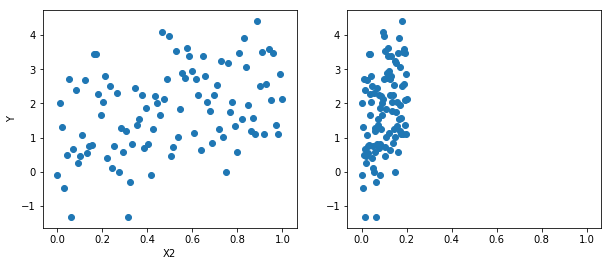

In [4]:
%matplotlib inline
fig,axes=plt.subplots(1,2,sharex=True,figsize=(10,4))
axes[0].scatter(X1,Y)
axes[1].scatter(X2,Y)
axes[0].set_ylabel('Y');axes[0].set_xlabel('X1');axes[0].set_xlabel('X2')

                                     Simulated regression data

## Model specification:

In [6]:
from pymc3 import Model, Normal, HalfNormal
# The following code implements the model in PyMC: 
basic_model = Model()
with basic_model:
    # Priors for unknown model parameters
    alpha = Normal('alpha',mu=0, sd=10)           #mu:mean ; sd:standard deviation; 
    beta = Normal('beta',mu=0, sd=10, shape=2)    #shape:the length or shape of the random variable
    sigma = HalfNormal('sigma',sd=1)
    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2
    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs',mu=mu, sd=sigma, observed=Y)

    All PyMC3 objects introduced in the indented code block below the with statement are added to the model behind the scenes.
    Inside a with statement, the first three statements create stochastic random variables with Normal prior distributions for the regression coefficients, and a half-normal distribution for the standard deviation of the observations.
    In general,a distribution's parameters are values that determine the location,shape or scale of the random variable,depending on the parameterization of the distribution.
    Most commonly used distributions,such as Beta, Exponential, Categorical, Gamma, Binomial and others, are available as PyMC3 objects.

  Y_obs = Normal('Y_obs',mu=mu, sd=sigma, observed=Y)

    This is a special case of a stochastic variable that we call an observed stochastic, and it is the data likelihood of the model.
    The data can be passed in the form of either a numpy.ndarry or pandas.DataFrame object.

    Detailed notes about distributions,sampling methods and other PyMC3 functions are available via the help function.

In [7]:
help(Normal)

Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Univariate normal log-likelihood.
 |  
 |  .. math::
 |  
 |     f(x \mid \mu, \tau) =
 |         \sqrt{\frac{\tau}{2\pi}}
 |         \exp\left\{ -\frac{\tau}{2} (x-\mu)^2 \right\}
 |  
 |  ========  ==========================================
 |  Support   :math:`x \in \mathbb{R}`
 |  Mean      :math:`\mu`
 |  Variance  :math:`\dfrac{1}{\tau}` or :math:`\sigma^2`
 |  ========  ==========================================
 |  
 |  Normal distribution can be parameterized either in terms of precision
 |  or standard deviation. The link between the two parametrizations is
 |  given by
 |  
 |  .. math::
 |  
 |     \tau = \dfrac{1}{\sigma^2}
 |  
 |  Parameters
 |  ----------
 |  mu : float
 |      Mean.
 |  sd : float
 |      Standard deviation (sd > 0).
 |  tau : float
 |      Precision (tau > 0).
 |  
 |  Method resolution order:
 |      Normal
 |      pymc3.distr

    PyMC3 random variables and data can be arbitrarily added, subtracted, divided, or multiplied together.

## Model fitting:
### MAP

In [8]:
from pymc3 import find_MAP
map_estimate=find_MAP(model=basic_model)
print(map_estimate)

Optimization terminated successfully.
         Current function value: 164.379479
         Iterations: 12
         Function evaluations: 17
         Gradient evaluations: 17
{'alpha': array(1.013664091407883), 'beta': array([ 1.46791597,  0.29358319]), 'sigma_log__': array(0.11928769449979053)}


    This will often occur in hierarchical models(分层模型) with the variance parameter for the random effect. 

In [9]:
from scipy import optimize
map_estimate = find_MAP(model=basic_model, fmin=optimize.fmin_powell)
print(map_estimate)

Optimization terminated successfully.
         Current function value: 164.380110
         Iterations: 6
         Function evaluations: 271
{'alpha': array(1.017552211498373), 'beta': array([ 1.51426781,  0.03520891]), 'sigma_log__': array(0.11815106834208673)}


### Gradient-based sampling methods

    PyMC3 implements several standard sampling algorithms, such as adaptive MetropolisHastings and adaptive slice sampling, but it's most capable step method is the No-U-Turn Sampler. PyMC3 relies on Theano to analytically compute model gradients via automatic differentiation of the posterior density.
    Here, we will use NUTS to sample 2000 draws from the posterior using the MAP as the starting and scaling point.

In [10]:
from pymc3 import NUTS, sample
with basic_model:
    # obtain starting values via MAP
    start = find_MAP(fmin=optimize.fmin_powell)
    # instantiate sampler
    step = NUTS(scaling=start)
    # draw 2000 posterior samples
    trace = sample(2000, step, start=start)

Optimization terminated successfully.
         Current function value: 164.380110
         Iterations: 6
         Function evaluations: 271


100%|██████████████████████████████████████| 2500/2500 [25:08<00:00,  1.26it/s]


    The first dimension of the array is the sampling index and the later dimensions match the shape of the variable. 

In [11]:
trace['alpha'][-5:]       #We can extract the last 5 values for the alpha variable.

array([ 1.1012173 ,  1.10632517,  0.93906177,  0.96871119,  1.22318961])

### Posterior analysis  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0A6AB150>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0A29CF70>]], dtype=object)

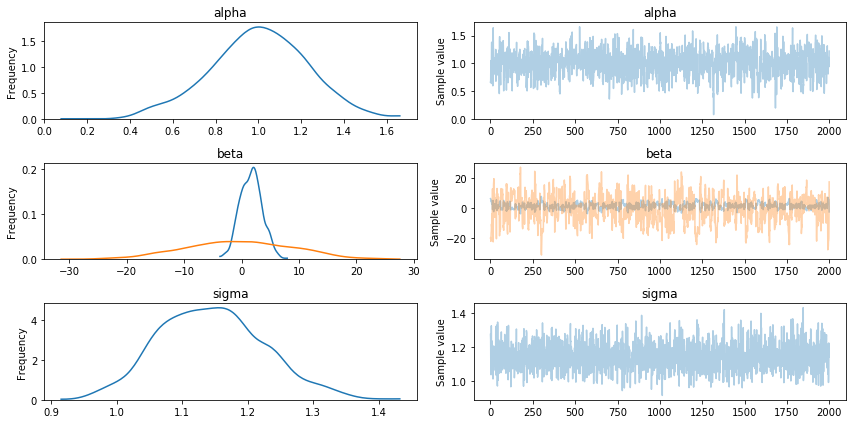

In [13]:
from pymc3 import traceplot
traceplot(trace)

                     Kernel density estimates and simulated trace for each variable in the linear regression model

    The left column consists of a smoothed histogram(using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the MarKov chain plotted in sequential order.

In [15]:
from pymc3 import summary
summary(trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.002            0.226            0.006            [0.520, 1.420]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.529          0.857          1.007          1.156          1.443


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.659            1.912            0.108            [-1.740, 5.422]
  -0.607           9.406            0.533            [-18.552, 16.975]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -1.819         0.266          1.719          2.925          5.383
  -18.997        -7.063         -0.6

# case study 1:stochastic volatility:
## The data

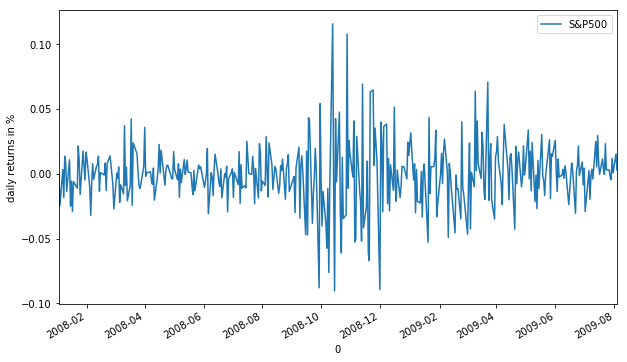

In [16]:
import pandas as pd
returns=pd.read_csv('C:/Users/Administrator/Desktop/PyMC3/uq_chapter-master/reference/data/SP500.csv',index_col=0,parse_dates=True)
returns.plot(figsize=(10,6))
plt.ylabel('daily returns in %')

              Historical daily returns of the S&P500 during the 2008 financial crisis 

## Model implementation:

In [17]:
from pymc3 import Exponential, StudentT, exp, Deterministic
from pymc3.distributions.timeseries import GaussianRandomWalk
with Model() as sp500_model:
    nu = Exponential('nu', 1./10, testval=5.)
    sigma = Exponential('sigma', 1./.02, testval=.1)
    s = GaussianRandomWalk('s', sigma**-2, shape=len(returns))
    volatility_process = Deterministic('volatility_process', exp(-2*s))
    r = StudentT('r', nu, lam=1/volatility_process, observed=returns['S&P500'])

ImportError: cannot import name 'exp'

## Question:

    Notice that we transform the log volatility process s into the volatility process by exp(-2*s). Here, exp is a Theano function, rather than the corresponding function in Numpy. 
    However, after install Theano successfully, there is no matching distribution found for "exp".
    So i use another formulation as follows:

In [19]:
import pymc3 as pm
with pm.Model() as sp500_model:
    nu = pm.Exponential('nu', 1./10, testval=5.)
    sigma = pm.Exponential('sigma', 1./.02, testval=.1)
    s = pm.GaussianRandomWalk('s', sigma**-2, shape=len(returns))
    volatility_process = pm.Deterministic('volatility_process', pm.math.exp(-2*s))
    r = pm.StudentT('r', nu, lam=1/volatility_process, observed=returns)

## Fitting:

    The Limited-memory BFGS(L-BFGS)optimizer is provided by the scipy.optimize package, this model includes 400 stochastic random variables(mostly from s)

In [ ]:
import scipy
with sp500_model:
    start=find_MAP(vars=[s],fmin=scipy.optimize.fmin_l_bfgs_b)
    step=NUTS(scaling=start)
    trace=sample(100,step,progressbar=False)
    #start next run at the last sampled position
    step=NUTS(scaling=trace[-1],gamma=.25)
    trace=sample(2000,step,start=trace[-1],progressbar=False,njobs=2)

这个过程运行时间非常长，我将其中断了。

In [ ]:
traceplot(trace, [nu, sigma])

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
returns.plot(ax=ax)
ax.plot(returns.index, 1/np.exp(trace['s',::30].T), 'r', alpha=.03);
ax.set(title='volatility_process', xlabel='time', ylabel='volatility');
ax.legend(['S&P500', 'stochastic volatility process'])

# case study 2: coal mining disasters:

    It implements a change-point model for a time series of recorded coal mining disasters in the UK from 1851-1962.
    There also have a pair of years with missing data, identified as missing by a NumPy MaskedArray using -999 as a sentinel value. In the presence of missing data, using multiple step methods to allow us to fit a model that includes both discrete and continuous random variables.

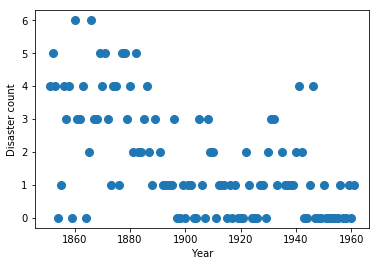

In [32]:
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
year = np.arange(1851, 1962)

plt.plot(year, disaster_data, 'o', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year")

  Recorded counts of coal mining disasters in the UK,1851-1962

    Counts of disasters in the time series is thought to follow a Poisson process, with a relatively large rate parameters in the early part of the time series, and a smaller rate in the later part.
    The Bayesian approach to such a problem is to treat the change point as an unknown quantity in the model, and assign it a prior distribution, which we update to a posterior using the evidence in the dataset. 

In [41]:
with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=year.min(), upper=year.max(), testval=1900)

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= year, early_rate, late_rate)

    disasters = pm.Poisson('disasters', rate, observed=disaster_data)

    Here, the sample function receives a list containing both the NUTS and Metropolis samplers, and sampling proceeds by first applying step1 then step2 at each iteration. 

In [43]:
from pymc3 import Metropolis
with disaster_model:
    step1 = NUTS([early_rate, late_rate])
    step2 = Metropolis([switchpoint, disasters.missing_values[0]] )
    trace = sample(10000, step=[step1, step2])

100%|████████████████████████████████████| 10500/10500 [31:52<00:00,  5.06it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0A59E930>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x09D370F0>]], dtype=object)

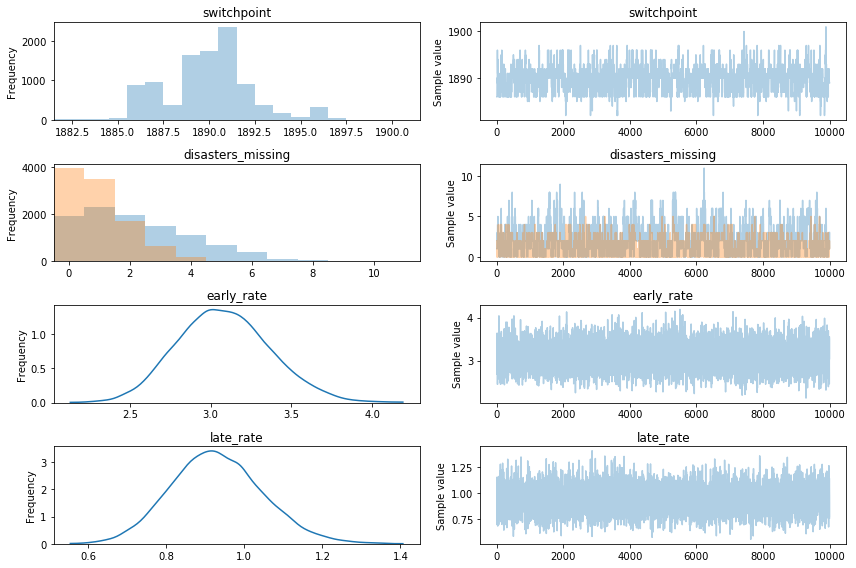

In [44]:
pm.traceplot(trace)

                      Posterior distributions and traces from disasters change point model

    We can see from the picture that there’s about a 10 year span that’s plausible for a significant change in safety, but a 5-year span that contains most of the probability mass. The distribution is jagged because of the jumpy relationship between the year switchpoint and the likelihood and not due to sampling error.

# PyMC3 features
## Arbitrary deterministic variables

In [45]:
import theano.tensor as T
from theano.compile.ops import as_op

@as_op(itypes=[T.lscalar], otypes=[T.lscalar])
def crazy_modulo3(value):
    if value > 0:
        return value % 3
    else :
        return (-value + 1) % 3

with Model() as model_deterministic:
    a = Poisson('a', 1)
    b = crazy_modulo3(a)

    Theano requires the types of the inputs and outputs of a function to be declared, which are specified for as_op by itypes for inputs and otypes for outputs. 
    An important drawback of this approach is that it is not possible for theano to inspect these functions in order to compute the gradient required for the Hamiltonian-based samplers. Therefore, it is not possible to use the HMC or NUTS samplers for a model that uses such an operator. However, it is possible to add a gradient if we inherit from theano.Op instead of using as_op.

## Arbitrary distributions

In [ ]:
import theano.tensor as T
from pymc3 import DensityDist, Uniform


with pm.Model() as model:
    alpha = pm.Uniform('intercept', -100, 100)

    # Create custom densities
    beta = DensityDist('beta', lambda value: -1.5 * T.log(1 + value**2), testval=0)
    eps = DensityDist('eps', lambda value: -T.log(T.abs_(value)), testval=1)

    # Create likelihood
    like = Normal('y_est', mu=alpha + beta * X, sd=eps, observed=Y)

In [56]:
from pymc3.distributions import Continuous
class Beta(Continuous):
    def __init__(self, mu, *args, **kwargs):
        super(Beta, self).__init__(*args, **kwargs)
        self.mu = mu
        self.mode = mu
    def logp(self, value):
        mu = self.mu
        return beta_logp(value - mu)
@as_op(itypes=[T.dscalar], otypes=[T.dscalar])
def beta_logp(value):
    return -1.5 * np.log(1 + (value)**2)
with Model() as model:
    beta = Beta('slope', mu=0, testval=0)

## Generalized linear models

In [60]:
# Convert X and Y to a pandas DataFrame
import pandas
df = pandas.DataFrame({'x1': X1, 'x2': X2, 'y': Y})
from pymc3.glm import GLM

with pm.Model() as model_glm:
    GLM.from_formula('y ~ x1 + x2', df)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 177.08:   6%|▋           | 11194/200000 [02:20<37:47, 83.28it/s]
Convergence archived at 11200
Interrupted at 11,200 [5%]: Average Loss = 244.12
100%|████████████████████████████████████▉| 998/1000 [1:29:41<00:13,  6.99s/it]C:\ProgramData\Anaconda3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:448: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
100%|████████████████████████████████████| 1000/1000 [1:29:41<00:00,  5.38s/it]


In [65]:
from pymc3.glm.families import Binomial

df_logistic = pandas.DataFrame({'x1': X1, 'y': Y > np.median(Y)})

with pm.Model() as model_glm_logistic:
    GLM.from_formula('y ~ x1', df_logistic, family=Binomial())

## Backends

    PyMC3 has support for different ways to store samples from MCMC simulation, called backends. These include storing output in-memory, in text files, or in a SQLite database. Specifying a SQLite backend, for example, as the trace argument to sample will instead result in samples being saved to a database that is initialized automatically by the model.

In [66]:
from pymc3.backends import SQLite
with model_glm_logistic:
    backend=SQLite('logistic_trace.sqlite')
    trace=sample(5000,Metropolis(),trace=backend)    

100%|██████████████████████████████████████| 5500/5500 [02:35<00:00, 35.31it/s]


In [67]:
from pymc3.backends.sqlite import load
with basic_model:
    trace_loaded=load('logistic_trace.sqlite')